In [391]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [392]:
engine = create_engine('sqlite:///movies.db', echo=False)
conn=engine.connect()

In [393]:
df = pd.read_sql("SELECT * FROM movie_data", conn)

In [394]:
df.head(2)

,id,title,rated,released,runtime,director,writer,actors,plot,language,...,boxoffice,response,genre,star,budget,gross,year,internet_movie_database_rating,rotten_tomato_rating,metacritic_rating
0,1,Inception,PG-13,2010-07-16 00:00:00.000000,148,Christopher Nolan,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",A thief who steals corporate secrets through t...,"English, Japanese, French",...,292576195.0,1,Action,Leonardo DiCaprio,160000000.0,836836967.0,2010,8.8,87.0,74.0
1,2,Iron Man 2,PG-13,2010-05-07 00:00:00.000000,124,Jon Favreau,"Justin Theroux, Stan Lee, Don Heck","Robert Downey Jr., Mickey Rourke, Gwyneth Paltrow",With the world now aware of his identity as Ir...,"English, French, Russian",...,312433331.0,1,Action,Robert Downey Jr.,200000000.0,623933331.0,2010,7.0,72.0,57.0


In [395]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1774 non-null   int64  
 1   title                           1774 non-null   object 
 2   rated                           1774 non-null   object 
 3   released                        1774 non-null   object 
 4   runtime                         1774 non-null   int64  
 5   director                        1774 non-null   object 
 6   writer                          1774 non-null   object 
 7   actors                          1774 non-null   object 
 8   plot                            1774 non-null   object 
 9   language                        1774 non-null   object 
 10  country                         1774 non-null   object 
 11  awards                          1774 non-null   object 
 12  metascore                       17

In [396]:
df=df.drop('id',axis=1)

In [337]:
#Filling nul values

df["rated"].fillna("NA", inplace = True)
df["director"].fillna("NA", inplace = True)
df["writer"].fillna("NA", inplace = True)
df["language"].fillna("NA", inplace = True)
df["country"].fillna("NA", inplace = True)
df["awards"].fillna("NA", inplace = True)
df["metascore"].fillna(0, inplace = True)
df["dvd"].fillna("NA", inplace = True)
df["boxoffice"].fillna(0, inplace = True)
df["budget"].fillna(0, inplace = True)
df["gross"].fillna(0, inplace = True)


In [338]:
#checking null values
df.isnull().sum()

title                             0
rated                             0
released                          0
runtime                           0
director                          0
writer                            0
actors                            0
plot                              0
language                          0
country                           0
awards                            0
metascore                         0
imdbrating                        0
imdbvotes                         0
dvd                               0
boxoffice                         0
response                          0
genre                             0
star                              0
budget                            0
gross                             0
year                              0
internet_movie_database_rating    0
rotten_tomato_rating              0
metacritic_rating                 0
dtype: int64

## Data Preprocessing for model

### Adding label column based on IMDB Rating (rating(<=5): label 0,rating(>5 and <=7):label1,rating(>7):label2

In [339]:
df['label']=''
for index, row in df.iterrows():
    if (row['imdbrating']<=5):
        df.loc[index, 'label']=0
    elif (row['imdbrating']>5)&(row['imdbrating']<=7):
        df.loc[index, 'label']=1
    elif (row['imdbrating']>7):
        df.loc[index, 'label']=2

In [340]:
df['label'].value_counts()

1    1175
2     510
0      89
Name: label, dtype: int64

In [341]:
df['label'].dtype

dtype('O')

In [342]:
df['label']=pd.to_numeric(df['label'])
df['label'].fillna(0,inplace=True)
df['label']=df['label'].astype('int')

In [343]:
df['label']

0       2
1       1
2       2
3       2
4       1
       ..
1769    1
1770    0
1771    0
1772    0
1773    1
Name: label, Length: 1774, dtype: int64

### Checking data cluster for some important features

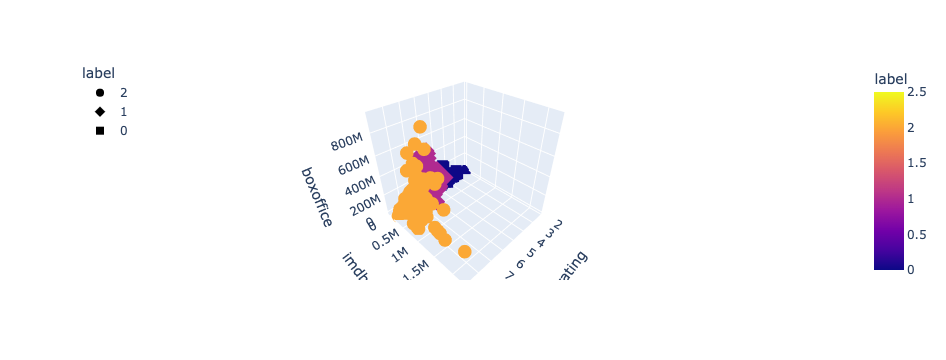

In [344]:
import plotly.express as px
fig = px.scatter_3d(
    df,
    x='imdbrating',
    y='imdbvotes',
    z='boxoffice',
    color="label",
    symbol="label",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

### Dropping Columns not required for the model

In [345]:
df=df.drop(['title','released','awards','metascore','imdbrating' ,'imdbvotes','dvd',
           'boxoffice','response','gross', 'year','internet_movie_database_rating',
           'rotten_tomato_rating','metacritic_rating'],axis=1)                                                 
df.columns

Index(['rated', 'runtime', 'director', 'writer', 'actors', 'plot', 'language',
       'country', 'genre', 'star', 'budget', 'label'],
      dtype='object')

### Create Function for one hot encoding of writer, actors,language, country columns

In [346]:
def one_hot_encode(column,new_col_names):
    
    for index, row in df.iterrows():
        item_names=str(row[column]).split(',')
        for y in item_names:
            y=y.strip()
            if y in new_col_names:
                df.loc[index, y]=1
        

### One Hot Endcoding: Country

In [347]:
from collections import Counter
# Find most common country names
countries=df['country'].to_list()

country_list=[]

for x in countries:
    
        country_array = str(x).split(',')
        for y in country_array:
            y=y.strip()
            country_list.append(y)
most_common=Counter(country_list).most_common(10)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('country',new_col_names)

In [348]:
len(df.columns)

22

### One Hot Encoding : Language

In [349]:
languages=df['language'].to_list()

language_list=[]

for x in languages:
    
        language_array = str(x).split(',')
        for y in language_array:
            y=y.strip()
            language_list.append(y)
most_common=Counter(language_list).most_common(15)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('language',new_col_names)


In [350]:
len(df.columns)

37

### One Hot Encoding :writer

In [351]:
writers=df['writer'].to_list()

writer_list=[]

for x in writers:
    
        writer_array = str(x).split(',')
        for y in writer_array:
            y=y.strip()
            writer_list.append(y)
most_common=Counter(writer_list).most_common(50)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('writer',new_col_names)

In [352]:
len(df.columns)

87

### One Hot Encoding :actors

In [353]:
actors=df['actors'].to_list()

actor_list=[]

for x in actors:
    
        actor_array = str(x).split(',')
        for y in actor_array:
            y=y.strip()
            actor_list.append(y)
most_common=Counter(actor_list).most_common(50)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('actors',new_col_names)



In [354]:
len(df.columns)

137

In [355]:
df=df.drop(['country','language','writer','actors'],axis=1)

In [356]:
df.columns

Index(['rated', 'runtime', 'director', 'plot', 'genre', 'star', 'budget',
       'label', 'United States', 'United Kingdom',
       ...
       'Jessica Chastain', 'Chris Evans', 'Mark Ruffalo', 'Nicolas Cage',
       'Chloë Grace Moretz', 'Johnny Depp', 'Kristen Stewart', 'Amy Adams',
       'Robert De Niro', 'Chris Pine'],
      dtype='object', length=133)

In [357]:
df.shape

(1774, 133)

In [358]:
df.fillna(0,inplace=True)


In [359]:
df.isnull().sum()

rated              0
runtime            0
director           0
plot               0
genre              0
                  ..
Johnny Depp        0
Kristen Stewart    0
Amy Adams          0
Robert De Niro     0
Chris Pine         0
Length: 133, dtype: int64

In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Columns: 133 entries, rated to Chris Pine
dtypes: float64(1), int64(2), object(130)
memory usage: 1.8+ MB


### Reducing type of rated by merging two or more types in one

In [361]:
df.loc[df['rated']=='TV-MA', 'rated'] = 'R'
df.loc[df['rated']=='NC-17', 'rated'] = 'R'
df.loc[df['rated']=='TV-14', 'rated'] = 'PG-13'
df.loc[df['rated']=='TV-PG', 'rated'] = 'PG'
df.loc[df['rated']=='Unrated', 'rated'] = 'NA'
df.loc[df['rated']=='Not Rated', 'rated'] = 'NA'

In [362]:
df['rated'].value_counts()

R        821
PG-13    602
PG       198
NA       142
G         11
Name: rated, dtype: int64

### Reducing Number of stars

In [363]:
stars = df.star.value_counts()

In [364]:
stars_replace = stars[stars<5].index.to_list()
for star in stars_replace:
      df['star'] =  df['star'].replace(star,'other_star')

df['star'].value_counts() 

other_star              1197
Mark Wahlberg             13
Matthew McConaughey       12
Matt Damon                12
Steve Carell              12
                        ... 
Paul Rudd                  5
Saoirse Ronan              5
Aaron Taylor-Johnson       5
James McAvoy               5
Alicia Vikander            5
Name: star, Length: 82, dtype: int64

### Reducing Number of Directors

In [365]:
df[['director1', 'director2', 'dire3']] = df['director'].str.split(',', expand=True)

In [366]:
df=df.drop(['director2','dire3','director'],axis=1)

In [367]:
df.rename(columns={'director1':'director'},inplace=True)

In [368]:
df['director']

0        Christopher Nolan
1              Jon Favreau
2          Martin Scorsese
3             Edgar Wright
4             Dennis Dugan
               ...        
1769            Jason Kwan
1770    Dylan Thomas Ellis
1771     Jeffrey Nicholson
1772    David Stuart Snell
1773          Monia Chokri
Name: director, Length: 1774, dtype: object

In [369]:
directors=df.director.value_counts()

In [370]:
directors_replace = directors[directors<4].index.to_list()
for director in directors_replace:
      df['director'] =  df['director'].replace(director,'other_director')
df.loc[df['director']=='NA', 'director'] = 'other_director'

df['director'].value_counts() 

other_director       1443
Ridley Scott           10
Robert Schwentke        8
Clint Eastwood          7
Steven Spielberg        7
                     ... 
Richard Linklater       4
Martin Scorsese         4
Jake Kasdan             4
Bryan Singer            4
Robert Zemeckis         4
Name: director, Length: 73, dtype: int64

### Counting No of genre

In [173]:
df['genre'].value_counts()

Action       504
Comedy       367
Drama        357
Biography    143
Animation    120
Crime         91
Adventure     88
Horror        84
Fantasy        6
Mystery        4
Thriller       3
Musical        2
Romance        2
Sci-Fi         1
Family         1
Sport          1
Name: genre, dtype: int64

### getting dummies on categorical columns

In [174]:
df_categorical=df[['rated','director','genre','star']]
df=df.drop(['rated','director','genre','star'],axis=1)

In [175]:
df_categorical_dummies=pd.get_dummies(df_categorical)
df_categorical_dummies.shape

(1774, 176)

In [331]:
for x in df_categorical_dummies.columns:
    print(x)

rated_G
rated_NA
rated_PG
rated_PG-13
rated_R
director_Anthony Russo
director_Antoine Fuqua
director_Baltasar Kormákur
director_Ben Wheatley
director_Brad Peyton
director_Bryan Singer
director_Chris Buck
director_Christopher Nolan
director_Clint Eastwood
director_Craig Gillespie
director_Daniel Espinosa
director_Danny Boyle
director_David Ayer
director_David Fincher
director_David O. Russell
director_David Yates
director_Denis Villeneuve
director_Dennis Dugan
director_Doug Liman
director_Eli Roth
director_Francis Lawrence
director_Gus Van Sant
director_Guy Ritchie
director_J.J. Abrams
director_Jake Kasdan
director_James Bobin
director_James Wan
director_Jaume Collet-Serra
director_Joe Wright
director_John Erick Dowdle
director_John Madden
director_Jon M. Chu
director_Jon Watts
director_Jonathan Levine
director_Jonathan Liebesman
director_Justin Lin
director_Kenneth Branagh
director_Lars von Trier
director_Lasse Hallström
director_Louis Leterrier
director_Luc Besson
director_Malcolm D. 

### Merging dummies col with dataframe

In [176]:
df=pd.merge(df, df_categorical_dummies, left_index=True, right_index=True)
df.shape

(1774, 305)

In [177]:
#separating plot column for processing

df_plot=df[['plot']]
df=df.drop('plot',axis=1)

In [178]:
# changing datatypes to floating for model
for col in df.columns:
    df[col]=pd.to_numeric(df[col])
    

In [179]:
df.isnull().sum()

runtime                 0
budget                  0
label                   0
United States         289
United Kingdom       1394
                     ... 
star_Vin Diesel         0
star_Will Ferrell       0
star_Will Smith         0
star_Zac Efron          0
star_other_star         0
Length: 304, dtype: int64

In [180]:
df=df.fillna(0)

In [181]:
df.isnull().sum()

runtime              0
budget               0
label                0
United States        0
United Kingdom       0
                    ..
star_Vin Diesel      0
star_Will Ferrell    0
star_Will Smith      0
star_Zac Efron       0
star_other_star      0
Length: 304, dtype: int64

### Plot transformation to features

In [182]:
df_plot = df_plot.replace(to_replace=',',value='', regex = True)

In [183]:
df_plot['plot'] = df_plot['plot'].str.replace(r'[^\w\s]+', '')

In [184]:
df_plot.head()

,plot
0,A thief who steals corporate secrets through t...
1,With the world now aware of his identity as Ir...
2,In 1954 a US Marshal investigates the disappea...
3,In a magically realistic version of Toronto a ...
4,After their high school basketball coach passe...


In [185]:
import nltk
nltk.download('punkt')
from nltk import sent_tokenize

[nltk_data] Downloading package punkt to /Users/Mimi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [186]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/Mimi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Mimi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [187]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
# stop_words=stopwords.words('english')

In [188]:
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /Users/Mimi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [189]:
stop_words=stopwords.words('english')

In [190]:
lemmatizer=WordNetLemmatizer()
i = 0
df_plot['newplot']=''
for  row in df_plot['plot']:
    word_tokens = word_tokenize(row)      
    filtered_sentence = [] 
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(lemmatizer.lemmatize(w))
    s =TreebankWordDetokenizer().detokenize(filtered_sentence)
    df_plot.at[i,'newplot']=s    
    i = i + 1

In [191]:
df_plot.head()

,plot,newplot
0,A thief who steals corporate secrets through t...,A thief steal corporate secret use dreamsharin...
1,With the world now aware of his identity as Ir...,With world aware identity Iron Man Tony Stark ...
2,In 1954 a US Marshal investigates the disappea...,In 1954 US Marshal investigates disappearance ...
3,In a magically realistic version of Toronto a ...,In magically realistic version Toronto young m...
4,After their high school basketball coach passe...,After high school basketball coach pass away f...


In [192]:
df_plot=df_plot.drop('plot',axis=1)

In [193]:
dataset=df_plot['newplot']
dataset

0       A thief steal corporate secret use dreamsharin...
1       With world aware identity Iron Man Tony Stark ...
2       In 1954 US Marshal investigates disappearance ...
3       In magically realistic version Toronto young m...
4       After high school basketball coach pass away f...
                              ...                        
1769    Serial billionaire kidnapper Logan savaging Ho...
1770    Fifteen yearold Taylor Collins golf legacy The...
1771    The Italian mob descends Mexican border take p...
1772    Three best friend head road trip desert one fi...
1773    Sophia unemployed academic forced change way t...
Name: newplot, Length: 1774, dtype: object

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfIdfVectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    strip_accents='ascii',
    max_features=70,
    use_idf=True,
    smooth_idf=True
  )

In [194]:
tfIdf = tfIdfVectorizer.fit_transform(dataset)

In [195]:
tfIdf.shape

(1774, 70)

In [196]:
# top features from dataset
top_features = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
top_features = top_features.sort_values('TF-IDF', ascending=False).index.tolist()

In [372]:
# saving vectorizer and top features to files
import joblib
joblib.dump(tfIdfVectorizer, "tdidf.joblib")

['tdidf.joblib']

In [198]:
# top 70 features from dataset
print('TOP WORDS')
print(top_features)

TOP WORDS
['past', 'secret', 'team', 'agent', 'return', 'son', 'set', 'school', 'save', 'relationship', 'story', 'power', 'police', 'people', 'order', 'new', 'mysterious', 'stop', 'student', 'american', 'time', 'town', 'travel', 'true', 'try', 'turn', 'war', 'way', 'wife', 'woman', 'work', 'world', 'year', 'york', 'mother', 'mission', 'meet', 'daughter', 'event', 'earth', 'discovers', 'discover', 'death', 'day', 'couple', 'man', 'come', 'city', 'child', 'brother', 'boy', 'begin', 'fall', 'family', 'father', 'fight', 'force', 'forced', 'friend', 'girl', 'group', 'help', 'high', 'home', 'house', 'lead', 'life', 'love', 'make', 'young']


In [199]:
#print('\nDataFrame head')
df3 = pd.DataFrame((tfIdf.toarray()), columns=tfIdfVectorizer.get_feature_names())[top_features]
print(df3.head(3))

       past    secret      team  agent  return  son  set  school  save  \
0  0.616952  0.575825  0.536466    0.0     0.0  0.0  0.0     0.0   0.0   
1  0.000000  0.000000  0.000000    0.0     0.0  0.0  0.0     0.0   0.0   
2  0.000000  0.000000  0.000000    0.0     0.0  0.0  0.0     0.0   0.0   

   relationship  ...  group  help  high  home  house  lead  life  love  make  \
0           0.0  ...    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0   
1           0.0  ...    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0   
2           0.0  ...    0.0   0.0   0.0   0.0    0.0   0.0   0.0   0.0   0.0   

   young  
0    0.0  
1    0.0  
2    0.0  

[3 rows x 70 columns]


### Merging plot features with original dataframe

In [200]:
df=pd.merge(df, df3, left_index=True, right_index=True)
df.shape

(1774, 374)

In [201]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier


### Splitting Feature and Target Columns

In [202]:
X=df.drop('label',axis=1)
y=df['label']

In [203]:
X.shape

(1774, 373)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=1)

In [205]:
scaler=StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

### Trying RandomForest Classifier

In [286]:
model=RandomForestClassifier (random_state=20,n_estimators=500,max_depth=14,min_samples_split=5)
model.fit(X_train_scaled,y_train)

RandomForestClassifier(max_depth=14, min_samples_split=5, n_estimators=500,
                       random_state=20)

In [287]:
from pickle import dump
#save model
dump(model, open('model.pkl', 'wb'))
# save the scaler
dump(scaler, open('scaler.pkl', 'wb'))

In [288]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [289]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.790491539081386,testing_score:0.7185741088180112


In [291]:
# from pickle import load

# tfIdf1= load(open('tfIdf.pickle', 'rb'))
# top_features1= load(open('top_features.pickle', 'rb'))

In [292]:
# tfIdfVectorizer = TfidfVectorizer(
#     stop_words='english',
#     lowercase=True,
#     strip_accents='ascii',
#     max_features=70,
#     use_idf=True,
#     smooth_idf=True
#   )

In [290]:

#vectorized_text=tfIdfVectorizer.fit_transform(['A thief steal corporate secret use dreamsharing technology given inverse task planting idea mind CEO tragic past may doom project team disaster'])


In [293]:
# vectorized_text.toarray()

In [294]:
# text_weight=vectorized_text.toarray()[0]

In [295]:
# text_weight=text_weight.tolist()

In [296]:
# word_list=tfIdfVectorizer.get_feature_names()

In [298]:
# #top_features,word_list,text_weight

# zeros=[0]*70

# for word in word_list:
#     if word in top_features:
#         word_id=top_features.index(word)
        
#         zeros[word_id]=text_weight[word_list.index(word)]
#zeros        

In [299]:
## Trying grid search for best hyper parameters

# model=RandomForestClassifier()
# param_grid={'n_estimators' :np.arange(50,500,50),
#             'max_depth': np.arange(3,20,2),
#             'max_leaf_nodes': np.arange(3,20,2)
# }
# grid_clf=GridSearchCV(model,param_grid)

In [619]:
# grid_clf.fit(X_train_scaled,y_train)

In [620]:
# print(grid_clf.best_params_)

In [621]:
# print(grid_clf.best_score_)

### Loading the saved model and testing data

In [753]:
from pickle import load
model = load(open('model.pkl', 'rb'))
# load the scaler
scaler = load(open('scaler.pkl', 'rb'))

In [755]:
X_test.shape

(533, 301)

In [768]:
test=X_test.iloc[0,:]

In [764]:
test.shape

(301,)

In [769]:
prediction=model.predict([test])

In [770]:
prediction

array([2])

### Trying SVC

In [306]:
from sklearn.svm import SVC

In [307]:
model=SVC(kernel='rbf',C=9,gamma=.0001)
model.fit(X_train_scaled,y_train)
#‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’

SVC(C=9, gamma=0.0001)

In [308]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [309]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.75825946817083,testing_score:0.699812382739212


In [310]:
model=SVC()
param_grid={'C':[1,5,10,50],
            'gamma':[0.0001,0.0005,0.001,0.005],
            'kernel':['linear','poly','rbf','sigmoid']
}
grid_clf=GridSearchCV(model,param_grid)

In [313]:
#grid_clf.fit(X_train_scaled,y_train)

In [314]:
#print(grid_clf.best_params_)

In [315]:
#print(grid_clf.best_score_)

### Trying K-Nearestneighbors

In [316]:
from sklearn.neighbors import KNeighborsClassifier

In [317]:
train_scores=[]
test_scores=[]

In [318]:
for k in range (1,20,2):
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled,y_train)
    train_score=knn.score(X_train_scaled,y_train)
    test_score=knn.score(X_test_scaled,y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)

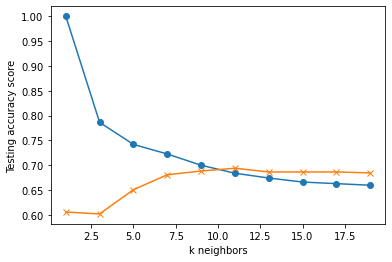

In [319]:
import matplotlib.pyplot as plt
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy score")
plt.show()

In [320]:
knn=KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_scaled,y_train)


KNeighborsClassifier(n_neighbors=10)

In [321]:
training_score = knn.score(X_train_scaled, y_train)
testing_score = knn.score(X_test_scaled, y_test)

In [322]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.6913779210314263,testing_score:0.6941838649155723


### Trying other ensemble methods

In [323]:
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier

### ExtraTreesClassifier

In [324]:
model=ExtraTreesClassifier()
model.fit(X_train_scaled,y_train)

ExtraTreesClassifier()

In [325]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [326]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:1.0,testing_score:0.6791744840525328


### AdaBoostClassifier

In [327]:
model=AdaBoostClassifier()
model.fit(X_train_scaled,y_train)

AdaBoostClassifier()

In [328]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [329]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.6994359387590653,testing_score:0.6604127579737336


In [374]:
zeros=np.zeros(303)
zeros

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [375]:
ones=np.ones(70)

In [376]:
ones

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [378]:
np.concatenate((zeros,ones),axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.